# RomyEvents - Manual Eventplots

Creates automatic event plots based on catalog 

In [68]:
# set interactive status plot
#%matplotlib tk

In [69]:
import os
import gc
import obspy as obs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import andbro__fft
import matplotlib.colors
import timeit
import sys
import warnings
from pprint import pprint
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.querrySeismoData import __querrySeismoData
from obspy.geodetics import gps2dist_azimuth
from pprint import pprint
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.querrySeismoData import __querrySeismoData
from functions.computeADRromy import __compute_romy_adr, __get_data, __adjust_time_line, __check_samples_in_stream
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, Stream, read_inventory, read
from obspy.clients import fdsn
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics import locations2degrees
from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal import array_analysis as AA
from obspy.signal.util import util_geo_km
from obspy.signal.rotate import rotate2zne
from datetime import datetime
from PIL import Image
from matplotlib.gridspec import GridSpec

In [70]:
font_title=17
font_ax=13
font_leg=11

### Methods

In [71]:
def makeplotDifferenceROMYADRsubplotslagoi(st, oadr, aadr, config, tplus, tminus):
    
    adr_locations = ['22', '23']
    adr_station = 'ROMY'
    adr_network = 'BW'
    adr_channel = 'BJZ'

    font = 11
    num_plots = len(adr_locations) * 2

    

    height_ratios = []
    for _ in adr_locations:
        height_ratios.extend([2, 1])  # Datenplot 3x so hoch wie Differenzplot

    fig, axes = plt.subplots(
                        nrows=num_plots,
                        figsize=(16, 4 * len(adr_locations)),  # Höhe bleibt übersichtlich
                            sharex=True,
                        gridspec_kw={'height_ratios': height_ratios}
                            )

    if num_plots == 1:
        axes = [axes]

    # Hole Originalspur
    original_trace = None
    for tr in st:
        if tr.stats.station == adr_station and tr.stats.channel == adr_channel:
            original_trace = tr
            break

    if original_trace is None:
        raise ValueError("Originalspur ROMY.BJZ nicht gefunden")

    for i, loc in enumerate(adr_locations):
        if loc == '21':
            adr_trace = iadr.select(station=adr_station, location=loc, network=adr_network, channel=adr_channel)
        elif loc == '22':
            adr_trace = oadr.select(station=adr_station, location=loc, network=adr_network, channel=adr_channel)
        elif loc == '23':
            adr_trace = aadr.select(station=adr_station, location=loc, network=adr_network, channel=adr_channel)
        else:
            continue

        if not adr_trace:
            print(f"Keine Daten gefunden für Location {loc}")
            continue

        tr_adr = adr_trace[0]

        # Trimmen VOR Cross-Korrelation
        tr1_full, tr2_full = original_trace.copy(), tr_adr.copy()
        common_start = max(tr1_full.stats.starttime, tr2_full.stats.starttime) + tplus
        common_end = min(tr1_full.stats.endtime, tr2_full.stats.endtime) - tminus
        tr1_full.trim(starttime=common_start, endtime=common_end)
        tr2_full.trim(starttime=common_start, endtime=common_end)

        if tr1_full.stats.sampling_rate != tr2_full.stats.sampling_rate:
            tr2_full.resample(tr1_full.stats.sampling_rate)

        # Angleichen der Länge
        minlen = min(len(tr1_full.data), len(tr2_full.data))
        tr1_full.data = tr1_full.data[:minlen]
        tr2_full.data = tr2_full.data[:minlen]

        # Kreuzkorrelation zur Lag-Bestimmung
        tr1_norm = (tr1_full.data - np.mean(tr1_full.data)) / np.std(tr1_full.data)
        tr2_norm = (tr2_full.data - np.mean(tr2_full.data)) / np.std(tr2_full.data)
        corr = np.correlate(tr1_norm, tr2_norm, mode='full')
        lag = np.argmax(corr) - (len(tr1_norm) - 1)
        max_corr = np.max(corr) / len(tr1_norm)
        time_shift = lag / tr1_full.stats.sampling_rate
        print(f"Lag für {loc}: {lag} Samples → {time_shift:.3f} s")

        # Zeitverschobene ADR-Spur
        tr2_shifted = tr_adr.copy()
        tr2_shifted.stats.starttime += time_shift

        # Finales Trimmen für den Plot
        tr1, tr2 = original_trace.copy(), tr2_shifted
        tr1.trim(starttime=common_start, endtime=common_end)
        tr2.trim(starttime=common_start, endtime=common_end)

        if tr1.stats.sampling_rate != tr2.stats.sampling_rate:
            tr2.resample(tr1.stats.sampling_rate)

        if len(tr1.data) != len(tr2.data):
            minlen = min(len(tr1.data), len(tr2.data))
            tr1.data = tr1.data[:minlen]
            tr2.data = tr2.data[:minlen]
        tr1.data = tr1.data*1000000000
        tr2.data = tr2.data*1000000000
        # Zeitvektor ab neuem Start
        times = np.linspace(0, tr1.stats.delta * (len(tr1.data) - 1), len(tr1.data))
        # Plot: Original vs ADR
        ax_data = axes[i * 2]
        ax_data.plot(times, tr1.data, label='direct recording ROMY.BJZ', lw=1)
        ax_data.plot(times, tr2.data, label=f'ADR ROMY.{loc}.BJZ', lw=1)
        ax_data.set_ylabel("rotation rate (nrad/s)", fontsize=font_ax)
        ax_data.legend(fontsize=8)
        # Entferne Titel, stattdessen Label
        ax_data.text(0.01, 0.95, f"{chr(97 + i * 2)})", transform=ax_data.transAxes,
                     fontsize=font + 2, fontweight='bold', va='top')

        # Plot: Differenz
        diff = np.abs(tr1.data - tr2.data)
        max_diff = np.max(diff)
        ax_diff = axes[i * 2 + 1]
        ax_diff.plot(times, diff, label=f'diff ADR vs ROMY.{loc}.BJZ', lw=1, color='red')
        ax_diff.set_ylabel("", fontsize=font)
        # Entferne Titel, stattdessen Label
        ax_diff.text(0.01, 0.95, f"{chr(97 + i * 2 + 1)})", transform=ax_diff.transAxes,
                     fontsize=font + 2, fontweight='bold', va='top')
        ax_diff.text(0.995, 0.9,
                   f"Max diff: {max_diff:.2e} nrad/s; CC: {max_corr:.3f}; Lag: {time_shift:.3f} s",
                   transform=ax_diff.transAxes,
                   ha='right', va='top', fontsize=font, color='black')
                

    # Achsenbeschriftung
    axes[-1].set_xlabel(f"Time (s) since {common_start.strftime('%Y-%m-%d %H:%M:%S')}", fontsize=font_ax)
    fig.text(0.5, 0.94, "comparison of direct ROMY recordings and array derived rotations (lag-corrected)", ha='center', va='top', fontsize=font_title)
    # Speicherpfad vorbereiten
    timestamp = config['tbeg'].strftime("%Y%m%d_%H%M%S")
    os.makedirs(config['outpath_figs'], exist_ok=True)
    save_path = os.path.join(config['outpath_figs'], f"difference_and_comparison_ROMY_BJZ_{timestamp}_lag.png")
    plt.subplots_adjust(hspace=0)  # Kein vertikaler Abstand
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Plot gespeichert unter: {save_path}")

    return fig


In [72]:
def makeplotDifferenceROMYADRsubplotsoi(st, oadr, aadr, config, tplus, tminus):

    adr_locations = ['22', '23']
    adr_station = 'ROMY'
    adr_network = 'BW'
    adr_channel = 'BJZ'

    font = 11
    num_plots = len(adr_locations) * 2  # Zwei Subplots pro Location

    height_ratios = []
    for _ in adr_locations:
        height_ratios.extend([2, 1])  # Datenplot 3x so hoch wie Differenzplot

    fig, axes = plt.subplots(
                        nrows=num_plots,
                        figsize=(16, 4 * len(adr_locations)),  # Höhe bleibt übersichtlich
                            sharex=True,
                        gridspec_kw={'height_ratios': height_ratios}
                            )

    if num_plots == 1:
        axes = [axes]

    # Hole Originalspur
    original_trace = None
    for tr in st:
        if tr.stats.station == adr_station and tr.stats.channel == adr_channel:
            original_trace = tr
            break

    if original_trace is None:
        raise ValueError("Originalspur ROMY.BJZ nicht gefunden")

    for i, loc in enumerate(adr_locations):
        if loc == '21':
            adr_trace = iadr.select(station=adr_station, location=loc, network=adr_network, channel=adr_channel)
        elif loc == '22':
            adr_trace = oadr.select(station=adr_station, location=loc, network=adr_network, channel=adr_channel)
        elif loc == '23':
            adr_trace = aadr.select(station=adr_station, location=loc, network=adr_network, channel=adr_channel)
        else:
            continue

        if not adr_trace:
            print(f"Keine Daten gefunden für Location {loc}")
            continue

        tr_adr = adr_trace[0]

        # Synchronisieren
        tr1, tr2 = original_trace.copy(), tr_adr.copy()
        common_start = max(tr1.stats.starttime, tr2.stats.starttime) + tplus
        common_end = min(tr1.stats.endtime, tr2.stats.endtime) - tminus

        tr1.trim(starttime=common_start, endtime=common_end)
        tr2.trim(starttime=common_start, endtime=common_end)

        if tr1.stats.sampling_rate != tr2.stats.sampling_rate:
            tr2.resample(tr1.stats.sampling_rate)

        if len(tr1.data) != len(tr2.data):
            minlen = min(len(tr1.data), len(tr2.data))
            tr1.data = tr1.data[:minlen]
            tr2.data = tr2.data[:minlen]
        tr1.data = tr1.data*1000000000
        tr2.data = tr2.data*1000000000
        # Zeit relativ zum neuen Startzeitpunkt berechnen
        times = np.linspace(0, tr1.stats.delta * (len(tr1.data) - 1), len(tr1.data))

        # Original vs ADR Plot
        ax_data = axes[i * 2]
        ax_data.plot(times, tr1.data, label='direct recording ROMY.BJZ', lw=1)
        ax_data.plot(times, tr2.data, label=f'ADR ROMY.{loc}.BJZ', lw=1)
        ax_data.set_ylabel("rotation rate (nrad/s)", fontsize=font_ax)
        ax_data.legend(fontsize=8)
        #ax_data.set_title(f"direct recordings of ROMY Z vs ADR: ROMY.{loc}.BJZ", fontsize=12)
        ax_data.text(0.01, 0.95, f"{chr(97 + i * 2)})", transform=ax_data.transAxes,
                     fontsize=font + 2, fontweight='bold', va='top')
        # Differenzplot
        diff = np.abs(tr1.data - tr2.data)
        max_diff = np.max(diff)
        ax_diff = axes[i * 2 + 1]
        # Kreuzkorrelation (z-normalisiert)
        tr1_norm = (tr1.data - np.mean(tr1.data)) / np.std(tr1.data)
        tr2_norm = (tr2.data - np.mean(tr2.data)) / np.std(tr2.data)
        corr = np.correlate(tr1_norm, tr2_norm, mode='valid')
        max_corr = np.max(corr) / len(tr1_norm)

        ax_diff.plot(times, diff, label=f'magnitude of the amplitude difference between ADR and ROMY.{loc}.BJZ', lw=1, color='red')
        ax_diff.set_ylabel("", fontsize=font)
        ax_diff.text(0.995, 0.94, f"Max diff: {max_diff:.2e} nrad/s; CC: {max_corr:.3f}",
                     transform=ax_diff.transAxes,
                     ha='right', va='top', fontsize=font, color='black'
                     )
        ax_diff.text(0.01, 0.95, f"{chr(97 + i * 2 + 1)})", transform=ax_diff.transAxes,
                     fontsize=font + 2, fontweight='bold', va='top')
    # Achsenbeschriftung mit Startzeit und relativer Zeit
    axes[-1].set_xlabel(f"Time (s) since {common_start.strftime('%Y-%m-%d %H:%M:%S')}", fontsize=font)
    #fig.suptitle("comparison of direct ROMY recordings and array derived rotations", fontsize=14)
    fig.text(0.5, 0.94, "comparison of direct ROMY recordings and array derived rotations", ha='center', va='top', fontsize=14)

    # Speicherpfad vorbereiten
    timestamp = config['tbeg'].strftime("%Y%m%d_%H%M%S")
    os.makedirs(config['outpath_figs'], exist_ok=True)
    save_path = os.path.join(config['outpath_figs'], f"difference_and_comparison_ROMY_BJZ_{timestamp}.png")
    #fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(hspace=0)  # Kein vertikaler Abstand
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Plot gespeichert unter: {save_path}")

    return fig


### Configurations

16.08.2024  00:16 28 Minuten
10.11.2024  17:15 30 Minuten
28.06.2024  06:20 27 Minuten
11.07.2024  15:40 35 Minuten
17.08.2024  19:40 43 Minuten

In [73]:
config = {}

# set start event time period (in UTC)
config['tbeg'] = obs.UTCDateTime("2024-08-17 19:40")  

# duration of event in seconds
config['duration'] = 43*60

# ROMY coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

# frequency range for bandpass filter
config['fmin'] = 0.03 # in Hz  gut 0.03
config['fmax'] = 0.2 # in Hz  gut 0.3

# path for figures to store
config['outpath_figs'] = "C:/Bachelorarbeit/Kombi/figures/"

# path for output data
config['outpath_data'] = "C:/Bachelorarbeit/Kombi/data/waveforms/"

# specify seed codes of stations that should be used for the analysis
config['seeds'] = ["BW.ROMY.10.BJZ", #"BW.ROMY..BJU", "BW.ROMY..BJV", "BW.ROMY..BJW", # ringlaser ROMY
                   "BW.RLAS..BJZ", # ringlaser G
                  ]

# path to catalogs
config['path_to_catalog'] = "C:/Bachelorarbeit/data/catalogs/"

# catalog file
config['catalog'] = "ROMY_global_catalog_20240501_20241224.pkl"

# set if existing files should be skipped
config['skip_existing'] = True

# set if figures should be saved
config['save_figures'] = True

# set if waveform data should be stored
config['store_waveforms'] = True

# set reference station
config['reference']= "GR.FUR"
    # specify stations to exclude
config['exclude'] = ['BW.ALFT']
    # ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941
    # set verbose
config['verbose'] = True

# RUN LOOP

Loop over events in catalog and request data for each event. Store data or event plots if
- skip existing files
- save figures
- store waveforms

is set in configurations, respectively.



In [74]:
# configuration adjustments for plots
config['title'] = f"{config['tbeg']} UTC"

# set start time as UTCDateTime object
config['tbeg'] = obs.UTCDateTime(str(config['tbeg']))

# same endtime
config['tend'] = config['tbeg'] + config['duration']

# initialize empty stream
st0 = obs.Stream()

errors = []

# load data
for seed in config['seeds']:
    try:      
        # request ringlaser data from george
        if "ROMY" in seed:
            stx, invx = __querrySeismoData( seed_id=seed,
                                            starttime=config['tbeg'],
                                            endtime=config['tend'],
                                            repository='george',
                                            path=None,
                                            restitute=True,
                                        detail=None,
                                        fill_value=None,
                                    )
            if len(stx) == 0:
                print(f" -> data missing for {seed}")

            st0 += stx
        else:
            print(f" -> {seed} not found")
                                        
    except Exception as e:
        print(e)
        print(f" -> failed to request {seed} for event ")
        errors.append(f" -> failed to request {seed} for event")
        continue

# stort stream by channel
st0 = st0.sort()

# check if any data is masked
for tr in st0:
    if isinstance(tr.data, np.ma.MaskedArray):
        print(f" -> {tr.stats.channel} has masked data. Filled with zeros.")
        tr.data = tr.data.filled(fill_value=0)

# processing data stream
print(" -> processing data stream ...")
st1 = st0.copy();
st1 = st1.detrend("linear");
st1 = st1.taper(0.1);
st1 = st1.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

# trim data stream
st1 = st1.trim(config['tbeg'], config['tend']);
st0 = st0.trim(config['tbeg'], config['tend']);

# store waveform data
if config['store_waveforms']:

    # define filename
    filename = f"{str(config['tbeg']).split('.')[0].replace('-','').replace(':','').replace(' ','_')}"

    # check if subdirectory exists
    if not os.path.isdir(config['outpath_data']):
        print("created: ", config['outpath_data'])
        os.makedirs(config['outpath_data'])

    # store waveform data
    try:
        st0.write(config['outpath_data']+filename+".mseed");
        print(f" -> stored at: {config['outpath_data']+filename}.mseed")
    except Exception as e:
        print(f" -> error storing waveform: {e}")
        errors.append(f" -> error storing waveform: {e}")

# saving figures
dt = config['tbeg']
zeit_str = dt.strftime("%Y%m%d_%H%M")
waveform_filename=zeit_str
waveform_filename_oadr=f"{waveform_filename}_oadr.mseed"
waveform_filename_aadr=f"{waveform_filename}_aadr.mseed"
if config['save_figures']:

    # check if subdirectory exists
    if not os.path.isdir(config['outpath_figs']+"raw/"):
        print("created: ", config['outpath_figs']+"raw/")
        os.makedirs(config['outpath_figs']+"raw/")
  

    # plotting figure
    fig1 = st0.plot(equal_scale=False, show=False);

    # store figure
    fig1.savefig(config['outpath_figs']+"raw/"+f"{filename}_raw.png", 
                    dpi=150, bbox_inches='tight', pad_inches=0.05)

    # check if subdirectory exists  
    if not os.path.isdir(config['outpath_figs']+"filtered/"):
        print("created: ", config['outpath_figs']+"filtered/")
        os.makedirs(config['outpath_figs']+"filtered/")

    # plotting figure
    fig2 = st1.plot(equal_scale=False, show=False);

    # store figure
    fig2.savefig(config['outpath_figs']+"filtered/"+f"{filename}_filtered.png", 
                    dpi=150, bbox_inches='tight', pad_inches=0.05)

    try:
            data_vorhanden=False
            if os.path.isfile(config['outpath_data']+waveform_filename_oadr):
                oadr=read(config['outpath_data']+waveform_filename_oadr)
                print('oadr wird aus Datei ausgelesen')
                data_vorhanden=True
            else:
                    oadr = __compute_romy_adr(config['tbeg'],
                                  config['tend'],
                                  submask='outer',
                                  ref_station=config['reference'],
                                  verbose=config['verbose'],
                                  excluded_stations=config['exclude'],
                                  map_plot=False,
                                 )

            oadr = oadr.trim(config['tbeg'], config['tend'], nearest_sample=False)

    except Exception as e:
            print(e)
            oadr = obs.Stream()

    # try to store data
    try:
        if not data_vorhanden:
            oadr.write(config['outpath_data']+waveform_filename_oadr)
            print(f"stored under {config['outpath_data']+waveform_filename_oadr}")
    except Exception as e:
            print(e)
    print(f"oadr result: {oadr}")
  
    #Compute ADR for entire array

    try:
            data_vorhanden=False
            if os.path.isfile(config['outpath_data']+waveform_filename_aadr):
                aadr=read(config['outpath_data']+waveform_filename_aadr)
                print('aadr wird aus Datei ausgelesen')
                data_vorhanden=True
            else:
                aadr = __compute_romy_adr(config['tbeg'],
                                  config['tend'],
                                  submask='all',
                                  ref_station=config['reference'],
                                  verbose=config['verbose'],
                                  excluded_stations=config['exclude'],
                                  map_plot=False,
                                 )

            aadr = aadr.trim(config['tbeg'], config['tend'], nearest_sample=False)

    except Exception as e:
            print(e)
            aadr = obs.Stream()
    
    # try to store data
    try:
            if not data_vorhanden:
                aadr.write(config['outpath_data']+waveform_filename_aadr)
                print(f"stored under {config['outpath_data']+waveform_filename_aadr}")
    except Exception as e: 
            print(e)
    print(f"aadr result: {aadr}")
    del fig1, fig2
    gc.collect()

pprint(errors)

 -> BW.RLAS..BJZ not found
 -> processing data stream ...
 -> stored at: C:/Bachelorarbeit/Kombi/data/waveforms/20240817T194000.mseed


C:\Users\bened\anaconda3\envs\ampratio\lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


oadr wird aus Datei ausgelesen
oadr result: 3 Trace(s) in Stream:
BW.ROMY.22.BJZ | 2024-08-17T19:40:00.040000Z - 2024-08-17T20:22:59.990000Z | 20.0 Hz, 51600 samples
BW.ROMY.22.BJN | 2024-08-17T19:40:00.040000Z - 2024-08-17T20:22:59.990000Z | 20.0 Hz, 51600 samples
BW.ROMY.22.BJE | 2024-08-17T19:40:00.039998Z - 2024-08-17T20:22:59.989998Z | 20.0 Hz, 51600 samples
aadr wird aus Datei ausgelesen
aadr result: 3 Trace(s) in Stream:
BW.ROMY.23.BJZ | 2024-08-17T19:40:00.040000Z - 2024-08-17T20:22:59.990000Z | 20.0 Hz, 51600 samples
BW.ROMY.23.BJN | 2024-08-17T19:40:00.039998Z - 2024-08-17T20:22:59.989998Z | 20.0 Hz, 51600 samples
BW.ROMY.23.BJE | 2024-08-17T19:40:00.040000Z - 2024-08-17T20:22:59.990000Z | 20.0 Hz, 51600 samples
[]


Plot gespeichert unter: C:/Bachelorarbeit/Kombi/figures/difference_and_comparison_ROMY_BJZ_20240817_194000.png


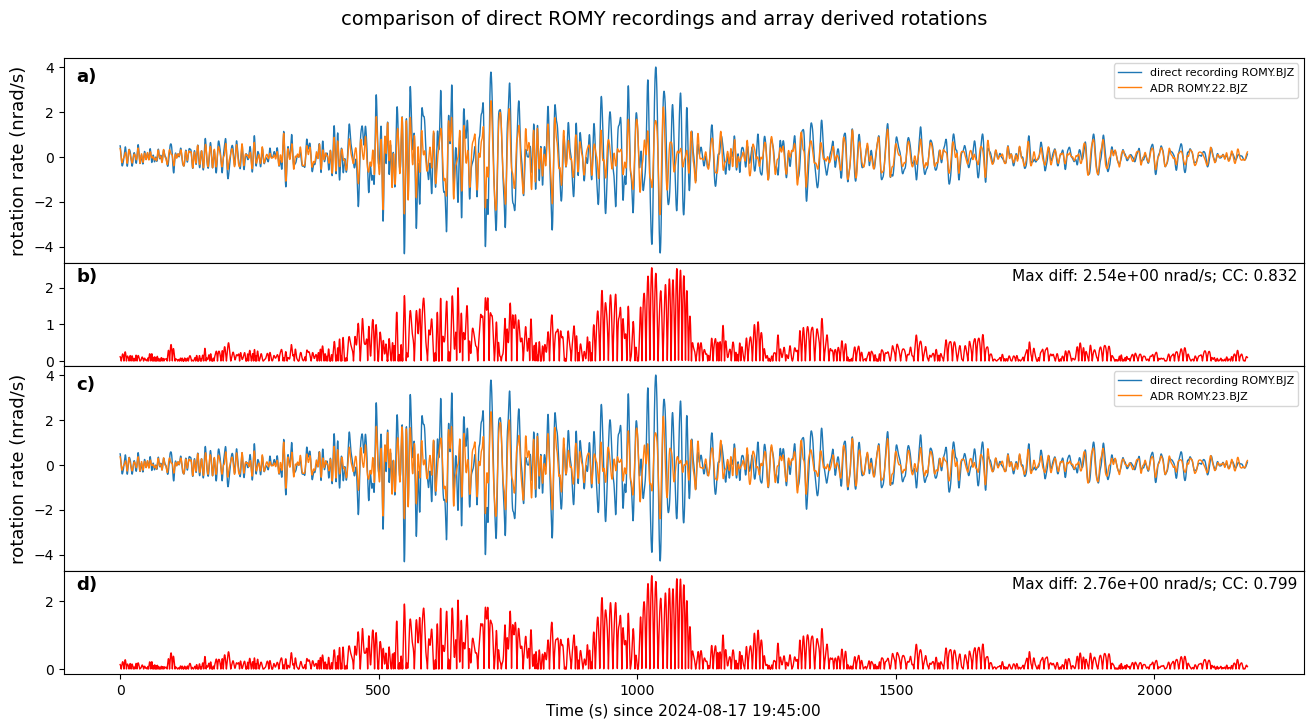

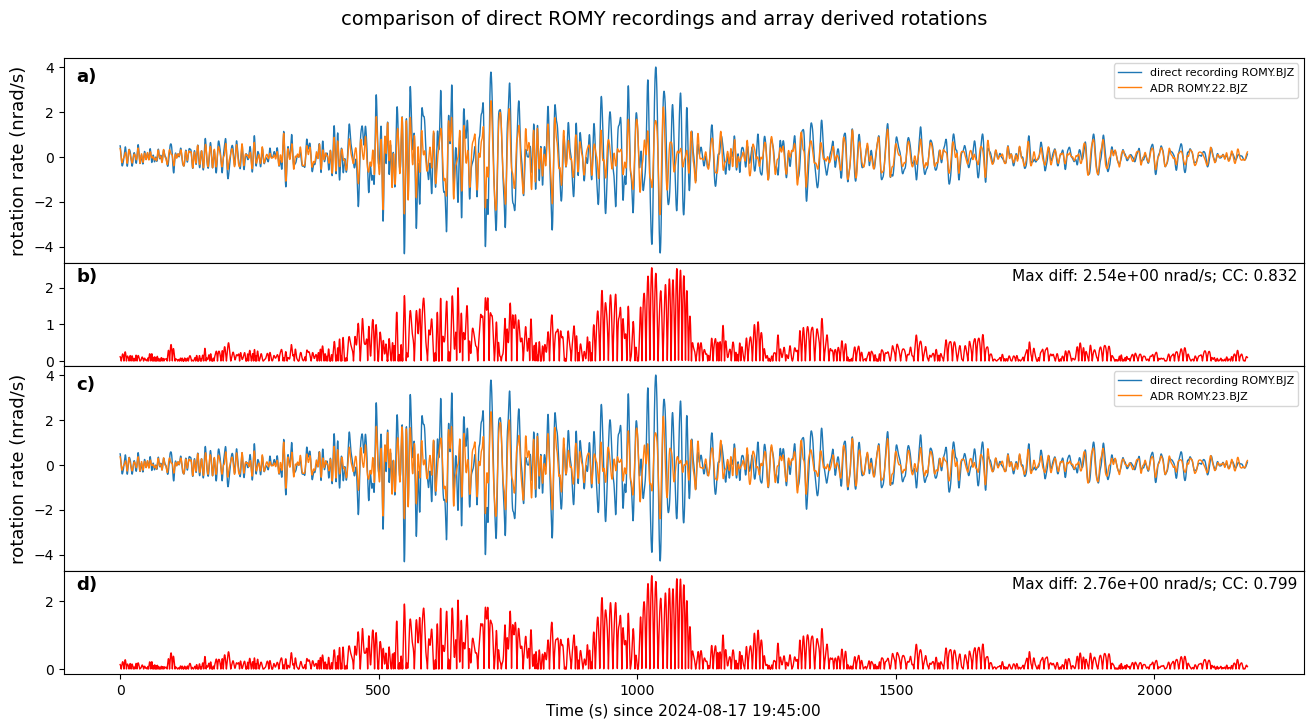

In [77]:
tplus =300
tminus =100
makeplotDifferenceROMYADRsubplotsoi(st1, oadr, aadr, config, tplus, tminus)

Lag für 22: 5 Samples → 0.250 s
Lag für 23: 5 Samples → 0.250 s
Plot gespeichert unter: C:/Bachelorarbeit/Kombi/figures/difference_and_comparison_ROMY_BJZ_20240817_194000_lag.png


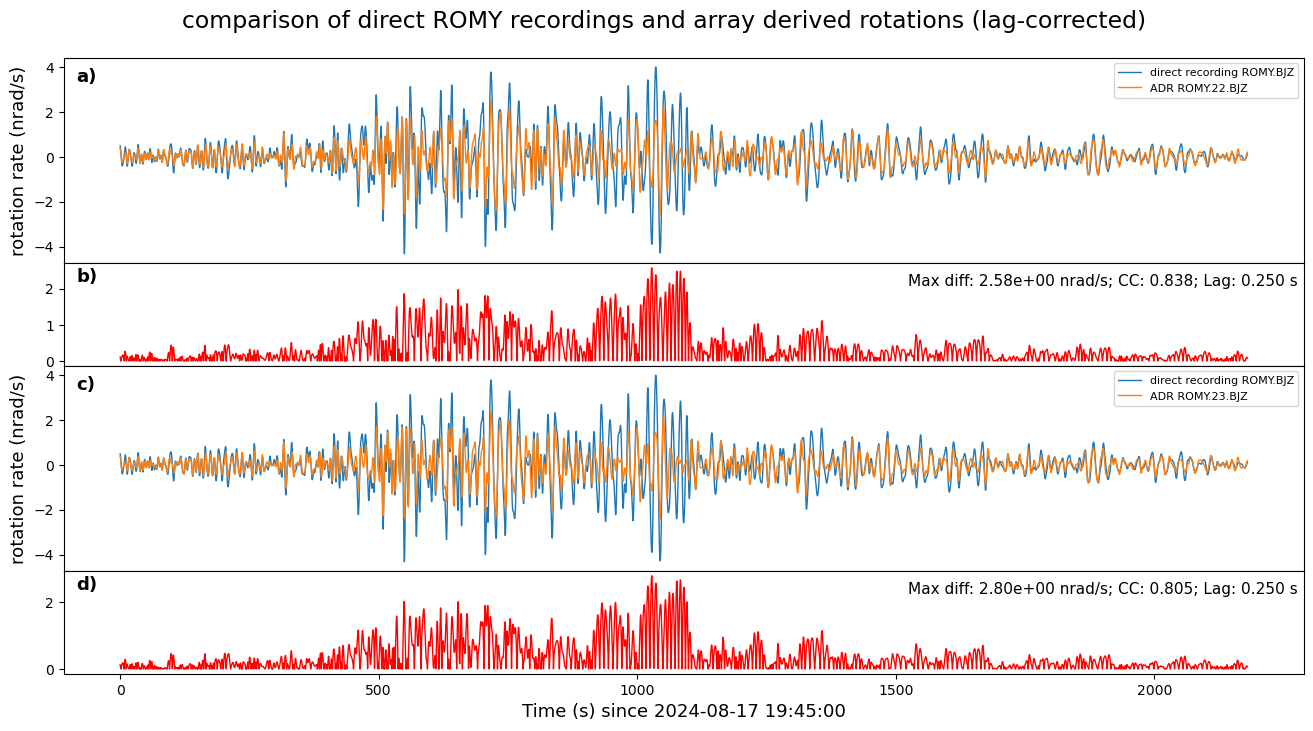

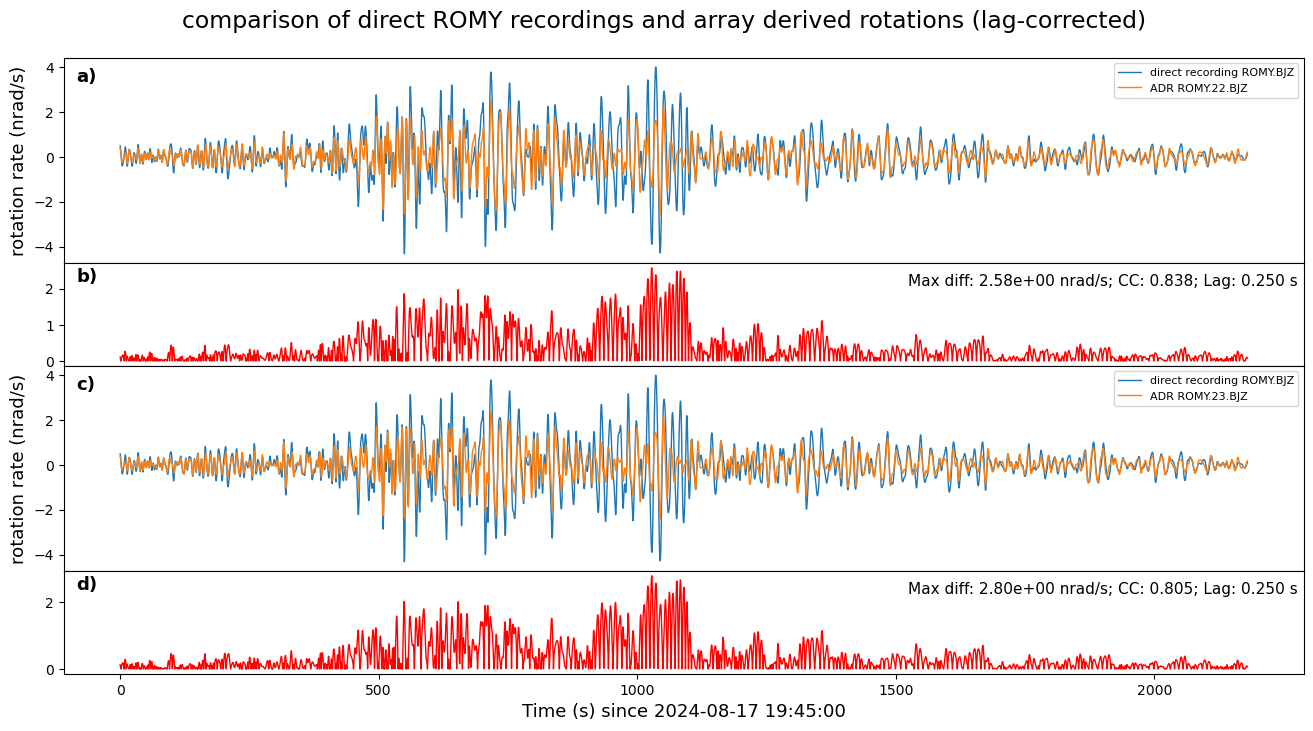

In [78]:
#makeplotDifferenceROMYADRsubplotslag(st1,iadr, oadr, aadr, config)
makeplotDifferenceROMYADRsubplotslagoi(st1, oadr, aadr, config, tplus, tminus )